# 처음에 시도했던 배경사진 VAE 재도전

그냥 [proj3](https://github.com/khodid/2020Evening/blob/master/proj3_MNIST_VAE.ipynb)에서 성공시킨 모델 그대로 사용할 거임

## 이미지 Import
1. Colab과 Google Drive 연결
2. dataloader 설정
3. 컴퓨팅 디바이스 설정

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


(-0.5, 47.5, 47.5, -0.5)

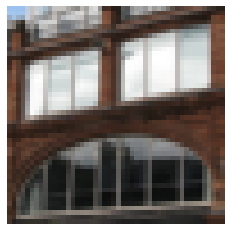

In [ ]:
import torchvision
from torchvision import transforms

root = '/content/gdrive/My Drive/Kaggle/scene-classification/train-scene classification/train'

trans= transforms.Compose([
                              transforms.Resize([48, 48]),
                              transforms.ToTensor()
])

train_data = torchvision.datasets.ImageFolder(root = root, transform= trans)

import matplotlib.pyplot as plt
showimg = train_data[10][0].numpy().transpose(1,2,0)

plt.imshow(showimg) # train_data[순서][0: 이미지 / 1: 라벨]
plt.axis('off')

In [ ]:
import torch.utils

# dataloader 설정
batch_size = 10
train_set = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle = True, drop_last = True)

In [ ]:
# 디바이스 설정
import torch.cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda' : torch.cuda.manual_seed_all(777)

In [ ]:
# Checking training data shape
print(type(train_set))
for img, label in train_set:
  break
print(img.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([10, 3, 48, 48])


## 모델 설정
1. 모델 정의(기존 proj3에서 그대로 따옴)
2. 모델 테스트
3. 모델 선언

In [ ]:
import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = nn.Sequential(
                                  # layer 1
                                  nn.Conv2d(3, 16, kernel_size = 5, stride = 1, padding = 2), # 3(48, 48) -> 16(48, 48)
                                  nn.BatchNorm2d(16),
                                  nn.ReLU(),
                                  
                                  #layer 2
                                  nn.Conv2d(16, 32, kernel_size = 5, stride = 2, padding=2), # 16(48, 48) -> 32(24, 24)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # layer 3
                                  nn. Conv2d(32, 32, kernel_size= 3, stride = 2, padding = 1), # 32(24, 24) -> 32(12, 12)
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),

                                  # output layer
                                  nn.Flatten()  # 32*12*12 = 4608
    )
    self.fc_mu = nn.Linear(4608, self.latent_size)
    self.fc_logvar = nn.Linear(4608, self.latent_size)
    self.fc_decode = nn.Linear(self.latent_size, 4608)
    self.decoder = nn.Sequential(
                                  # 
                                  # 3-T
                                  nn.ConvTranspose2d(32, 32, kernel_size = 3, stride = 2, padding=1, output_padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),

                                  # 2-T
                                  nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),

                                  # 1-T
                                  nn.ConvTranspose2d(16, 3, kernel_size=5, stride=1, padding=2),
                                  nn.Sigmoid()
    )
  def reparameterize(self, mu, var):
    sigma = torch.exp(0.5*var)
    epsilon = torch.randn_like(sigma)
    return mu + sigma * epsilon

  def encode(self, img):
    h = self.encoder(img)
    mu, log_var = self.fc_mu(h), self.fc_logvar(h)
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var

  def decode(self, z):
    z = self.fc_decode(z)
    new_img = self.decoder(z.view(z.size(0), 32, 12, 12))
    return new_img


====== ENCODER ======
torch.Size([20, 2])
====== DECODER ======
torch.Size([20, 3, 48, 48])


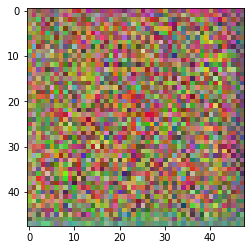

In [ ]:
# model test
with torch.no_grad():
  input = torch.randn(20, 3, 48, 48).to(device)
  model = VAE(latent_size = 2).to(device)
  test_z, _, _ = model.encode(input)
  test_out = model.decode(test_z)

  print('====== ENCODER ======')
  print(test_z.shape)
  print('====== DECODER ======')
  print(test_out.shape)

  import matplotlib.pyplot as plt
  if device == 'cuda': test_out = test_out.cpu()
  show = test_out[0].view(3, 48, 48).numpy().transpose(1,2,0)
  plt.imshow(show, cmap='gray')

In [ ]:
model = VAE(latent_size= 200).to(device)
model.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten()
  )
  (fc_mu): Linear(in_features=4608, out_features=200, bias=True)
  (fc_logvar): Linear(in_features=4608, out_features=200, bias=True)
  (fc_decode): Linear(in_features=200, out_features=4608, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

## 학습
여기 역시 proj3에서 그대로 따옴

In [ ]:
def loss_function(x, target, mu, log_var):
  x, target = x.view(-1,6912), target.view(-1, 6912) # 안 넣으면 오류남
  # r_loss = torch.sqrt(torch.mean(torch.square(target - x)) + 1e-7) # p98 참고 # 0 되는 걸 방지하기 위해
  r_loss = nn.functional.binary_cross_entropy(x, target, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
  return r_loss, kl_div, r_loss + kl_div

In [ ]:
# 진행상황 모니터링용
tags = ['Buildings', 'Forests','Glacier', 'Mountains', 'Sea', 'Street']

def compare_img(img, new_img, label, epoch):
  with torch.no_grad():
    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original_set = img.view(img.size(0), 3, 48, 48).numpy().transpose(0, 2,3,1)
    show_gen_set = new_img.view(new_img.size(0), 3, 48, 48).numpy().transpose(0,2,3,1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):
      show_original = show_original_set[i]
      show_gen = show_gen_set[i]

      plt.subplot(2, 8, i+1)
      plt.title('{}'.format(tags[label[i]]))
      plt.imshow(show_original, cmap='gray')
      plt.axis(False)
      plt.subplot(2, 8, i + 9)
      plt.imshow(show_gen, cmap = 'gray')
      plt.axis(False)
      
    plt.suptitle('Epoch:{}'.format(epoch+1), fontsize=16)
    plt.tight_layout()
    plt.savefig('VAE_scenery_train_{}.png'.format(epoch))
    plt.show()
    plt.clf() # 다음 그림 위해서 비워두기


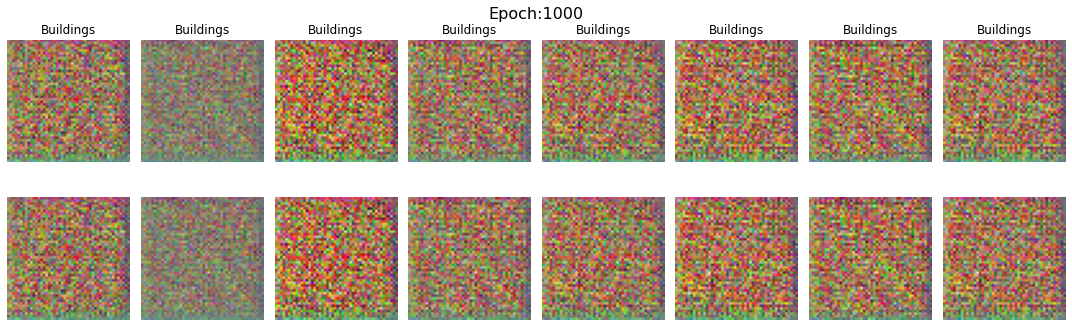

<Figure size 432x288 with 0 Axes>

In [ ]:
compare_img(test_out,test_out, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 999)

### 모델 저장

In [ ]:
MODEL_PATH = '/content/gdrive/My Drive/Kaggle/scene-classification/vae_model.pth'

In [ ]:
def save_model(model, optimizer, epoch, loss):
  checkpoint = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': loss}
  torch.save(checkpoint, MODEL_PATH)

In [ ]:
def load_model(l_size, MODEL_PATH):
  model = VAE(latent_size= l_size)
  optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

  checkpoint = torch.load(MODEL_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, optimizer, epochs, loss

## Training

img = img.to(device) 부분에서 

> CUDA error: device-side assert triggered

라는 오류가 발생했는데, [https://brstar96.github.io/shoveling/device_error_summary/](https://brstar96.github.io/shoveling/device_error_summary/)를 참고 해보니 이 문제는 복합적인 원인에 의해 일어나는 듯 했다.

나는 다음과 같은 해결 방법을 시도해봤다.

1. 런타임 유형을 CPU로 변경한다.(실패)
 - GPU 프로세싱 자체에서 문제가 발생했을 수 있다고 생각하여 런타임 유형을 GPU에서 CPU로 변경해보았다. 그 결과 새로 생성한 이미지의 값이 모두 NaN으로 출력되는 현상이 발생했다. 원인을 잘 모르겠다.
2. batch size를 줄여본다. (부분 실패)
 - 기존 batch size가 20이었던 것을 10으로 줄여 본다.
 - 1에서 에러가 발생한 원인을 찾음. batch size가 10일 때도 **loss가 16자리, 18자리에 육박하는 큰 수**였고, loss를 전부 합하는 방식을 채택했기 때문에 batch size가 20일 땐 훨씬 큰 수였기 때문에 오류가 발생했던 것 같음. batch size를 5로 축소했을 때도 같은 문제 발생. batch_size\*3\*64\*64 개의 loss의 총합을 구하는 것 자체가 너무 큰 것 같아서 이미지 사이즈 자체를 좀더 줄여보기로 함.
3. 이미지 크기를 줄여 본다.(성공)
  - 기존 3X64X64로 줄였던 것을 3X48X48로 다시 한 번 축소. 이미지의 형상을 알아보는 데엔 무리가 없음.
  - 3X64X64 =12288 --> 3X48X48=6912 로 계산해야 할 데이터량을 절반으로 줄임. loss 값도 4만 대로 연산 가능한 숫자로 확 줄어든 것을 관찰할 수 있었음.

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(),lr = 0.001)

In [ ]:
lenth = len(train_set)
print(lenth)

1702


Epoch [1/20] Step [200/1702] loss: 39364.5 rmse: 38698.125, kl_div: 666.3742065429688
Epoch [1/20] Step [400/1702] loss: 41565.52734375 rmse: 40900.046875, kl_div: 665.481689453125
Epoch [1/20] Step [600/1702] loss: 40498.34765625 rmse: 39894.71875, kl_div: 603.6278686523438
Epoch [1/20] Step [800/1702] loss: 41093.41796875 rmse: 40378.1875, kl_div: 715.232177734375
Epoch [1/20] Step [1000/1702] loss: 38676.27734375 rmse: 38023.2265625, kl_div: 653.0493774414062
Epoch [1/20] Step [1200/1702] loss: 39088.98046875 rmse: 38405.8359375, kl_div: 683.1431884765625
Epoch [1/20] Step [1400/1702] loss: 38235.97265625 rmse: 37562.046875, kl_div: 673.9271850585938
Epoch [1/20] Step [1600/1702] loss: 38318.25390625 rmse: 37707.16796875, kl_div: 611.0850830078125


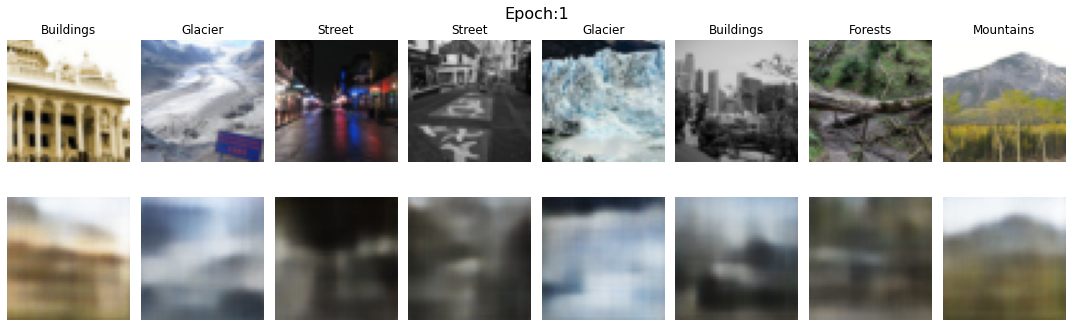

Epoch [2/20] Step [200/1702] loss: 39538.77734375 rmse: 38832.765625, kl_div: 706.0098876953125
Epoch [2/20] Step [400/1702] loss: 37234.34765625 rmse: 36585.6015625, kl_div: 648.74462890625
Epoch [2/20] Step [600/1702] loss: 38760.359375 rmse: 38079.578125, kl_div: 680.7813720703125
Epoch [2/20] Step [800/1702] loss: 38579.84765625 rmse: 37992.67578125, kl_div: 587.17236328125
Epoch [2/20] Step [1000/1702] loss: 41360.125 rmse: 40719.3515625, kl_div: 640.7725830078125
Epoch [2/20] Step [1200/1702] loss: 39075.51953125 rmse: 38392.6484375, kl_div: 682.8723754882812
Epoch [2/20] Step [1400/1702] loss: 42556.30078125 rmse: 41888.9296875, kl_div: 667.3729248046875
Epoch [2/20] Step [1600/1702] loss: 41647.25390625 rmse: 40966.33984375, kl_div: 680.9150390625
Epoch [3/20] Step [200/1702] loss: 38151.89453125 rmse: 37465.29296875, kl_div: 686.600830078125
Epoch [3/20] Step [400/1702] loss: 38056.4296875 rmse: 37370.5703125, kl_div: 685.857666015625
Epoch [3/20] Step [600/1702] loss: 40311.4

<Figure size 432x288 with 0 Axes>

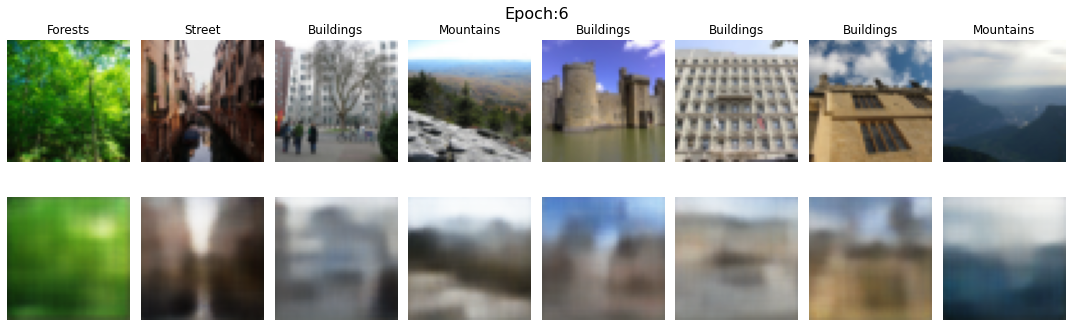

Epoch [7/20] Step [200/1702] loss: 38081.90625 rmse: 37456.39453125, kl_div: 625.5106201171875
Epoch [7/20] Step [400/1702] loss: 38115.83984375 rmse: 37464.78515625, kl_div: 651.0533447265625
Epoch [7/20] Step [600/1702] loss: 39040.828125 rmse: 38328.8125, kl_div: 712.0143432617188
Epoch [7/20] Step [800/1702] loss: 38431.26953125 rmse: 37847.515625, kl_div: 583.7523193359375
Epoch [7/20] Step [1000/1702] loss: 40190.2578125 rmse: 39450.59375, kl_div: 739.6622314453125
Epoch [7/20] Step [1200/1702] loss: 35870.921875 rmse: 35270.171875, kl_div: 600.7486572265625
Epoch [7/20] Step [1400/1702] loss: 40562.80859375 rmse: 39904.46875, kl_div: 658.341064453125
Epoch [7/20] Step [1600/1702] loss: 41354.91796875 rmse: 40577.859375, kl_div: 777.05859375
Epoch [8/20] Step [200/1702] loss: 42700.32421875 rmse: 41918.9921875, kl_div: 781.3314819335938
Epoch [8/20] Step [400/1702] loss: 39545.609375 rmse: 38940.80078125, kl_div: 604.810546875
Epoch [8/20] Step [600/1702] loss: 39120.88671875 rms

<Figure size 432x288 with 0 Axes>

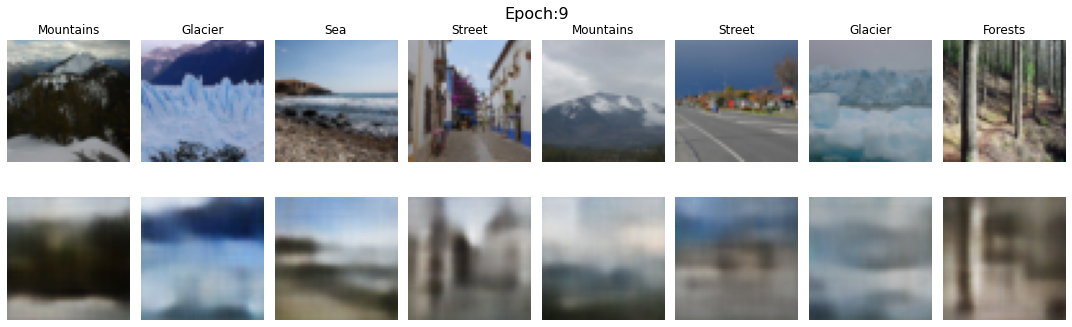

Epoch [10/20] Step [200/1702] loss: 40255.0546875 rmse: 39563.45703125, kl_div: 691.596435546875
Epoch [10/20] Step [400/1702] loss: 40461.21484375 rmse: 39809.02734375, kl_div: 652.1878051757812
Epoch [10/20] Step [600/1702] loss: 38023.3984375 rmse: 37326.9453125, kl_div: 696.45361328125
Epoch [10/20] Step [800/1702] loss: 38198.1328125 rmse: 37499.97265625, kl_div: 698.1619873046875
Epoch [10/20] Step [1000/1702] loss: 38637.8984375 rmse: 37987.33984375, kl_div: 650.5567626953125
Epoch [10/20] Step [1200/1702] loss: 41396.83203125 rmse: 40732.6328125, kl_div: 664.1993408203125
Epoch [10/20] Step [1400/1702] loss: 40653.59765625 rmse: 39974.05078125, kl_div: 679.5459594726562
Epoch [10/20] Step [1600/1702] loss: 38412.49609375 rmse: 37729.80859375, kl_div: 682.6861572265625
Epoch [11/20] Step [200/1702] loss: 39683.203125 rmse: 38955.9375, kl_div: 727.2665405273438
Epoch [11/20] Step [400/1702] loss: 39373.203125 rmse: 38671.015625, kl_div: 702.1873779296875
Epoch [11/20] Step [600/1

<Figure size 432x288 with 0 Axes>

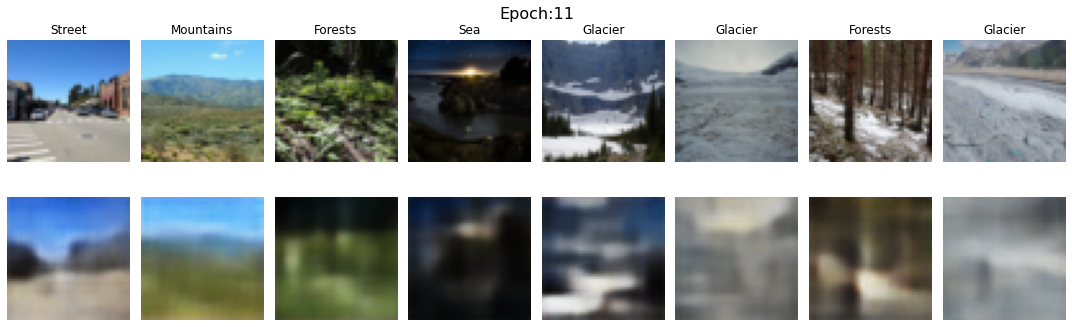

Epoch [12/20] Step [200/1702] loss: 40379.36328125 rmse: 39727.6015625, kl_div: 651.7616577148438
Epoch [12/20] Step [400/1702] loss: 35981.7265625 rmse: 35312.015625, kl_div: 669.71240234375
Epoch [12/20] Step [600/1702] loss: 37238.91796875 rmse: 36552.6015625, kl_div: 686.3168334960938
Epoch [12/20] Step [800/1702] loss: 39670.03515625 rmse: 38938.71875, kl_div: 731.31640625
Epoch [12/20] Step [1000/1702] loss: 39189.171875 rmse: 38542.2265625, kl_div: 646.9469604492188
Epoch [12/20] Step [1200/1702] loss: 43496.64453125 rmse: 42816.796875, kl_div: 679.84716796875
Epoch [12/20] Step [1400/1702] loss: 38782.0546875 rmse: 38155.8984375, kl_div: 626.1571044921875
Epoch [12/20] Step [1600/1702] loss: 42884.2109375 rmse: 42167.625, kl_div: 716.5857543945312
Epoch [13/20] Step [200/1702] loss: 38226.11328125 rmse: 37500.875, kl_div: 725.2399291992188
Epoch [13/20] Step [400/1702] loss: 39537.87109375 rmse: 38867.921875, kl_div: 669.9510498046875
Epoch [13/20] Step [600/1702] loss: 40795.8

<Figure size 432x288 with 0 Axes>

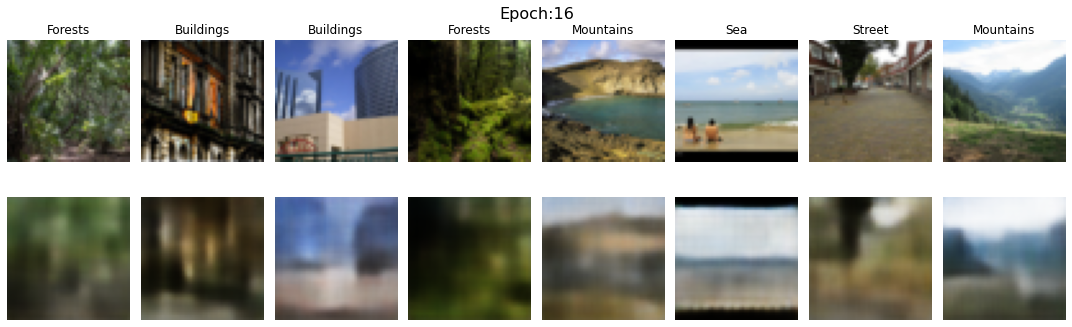

Epoch [17/20] Step [200/1702] loss: 41095.453125 rmse: 40479.96875, kl_div: 615.4840087890625
Epoch [17/20] Step [400/1702] loss: 40881.27734375 rmse: 40292.59765625, kl_div: 588.6780395507812
Epoch [17/20] Step [600/1702] loss: 39425.59765625 rmse: 38745.76171875, kl_div: 679.8350830078125
Epoch [17/20] Step [800/1702] loss: 37977.91015625 rmse: 37283.19921875, kl_div: 694.7095947265625
Epoch [17/20] Step [1000/1702] loss: 40281.3359375 rmse: 39570.1171875, kl_div: 711.2169189453125
Epoch [17/20] Step [1200/1702] loss: 41238.76171875 rmse: 40616.6953125, kl_div: 622.066162109375
Epoch [17/20] Step [1400/1702] loss: 39726.09765625 rmse: 39047.84375, kl_div: 678.2545776367188
Epoch [17/20] Step [1600/1702] loss: 39984.76171875 rmse: 39243.1015625, kl_div: 741.66162109375
Epoch [18/20] Step [200/1702] loss: 39392.75 rmse: 38716.75, kl_div: 676.0006103515625
Epoch [18/20] Step [400/1702] loss: 39385.01953125 rmse: 38684.328125, kl_div: 700.69189453125
Epoch [18/20] Step [600/1702] loss: 3

<Figure size 432x288 with 0 Axes>

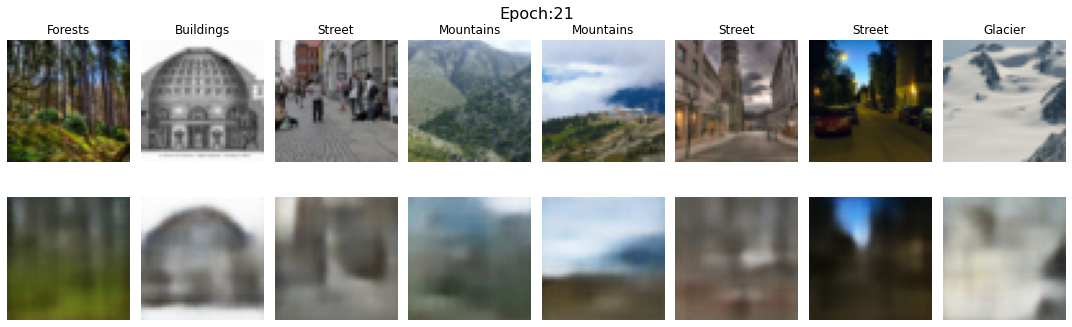

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = 20
tick = [0, 5, 8, 10, 15, 20, 30, 50, 100, 120, 150, 180, 200] 

model.train(True)

for epoch in range(epochs):
  for idx, (img, label) in enumerate(train_set):
    img = img.to(device)
    
    z, mu, var = model.encode(img)
    new_img = model.decode(z)
    r, k, loss = loss_function(new_img, img, mu, var)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (idx+1) % 200 is 0 : print('Epoch [{}/{}] Step [{}/{}] loss: {} rmse: {}, kl_div: {}'.format(epoch+1, epochs, idx+1, lenth, loss.item(), r.item(), k.item()))

  if epoch in tick : compare_img(img, new_img, label, epoch)
  save_model(model, optimizer, epoch, loss)

compare_img(img, new_img, label, epoch+1)

In [ ]:
save_model(model, optimizer, epoch, loss)

In [ ]:
compare_img(img, new_img, label, epoch)

In [ ]:
print(loss)

## 모델 세이브 / 로드 테스트

In [ ]:
mod, opt, ep, l = load_model(200, MODEL_PATH)
mod = mod.to(device)

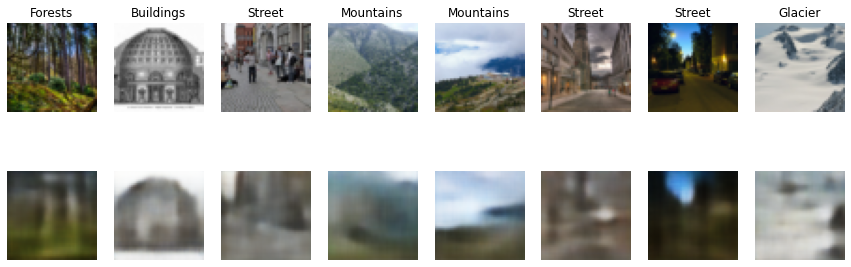

In [ ]:

with torch.no_grad():
    if device == 'cuda': img = img.to(device)
    
    z, mu, var = mod.encode(img)
    new_img = mod.decode(z)

    if device == 'cuda': img, new_img = img.cpu(), new_img.cpu()
    show_original_set = img.view(img.size(0), 3, 48, 48).numpy().transpose(0, 2,3,1)
    show_gen_set = new_img.view(new_img.size(0), 3, 48, 48).numpy().transpose(0,2,3,1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):
      show_original = show_original_set[i]
      show_gen = show_gen_set[i]

      plt.subplot(2, 8, i+1)
      plt.title('{}'.format(tags[label[i]]))
      plt.imshow(show_original, cmap='gray')
      plt.axis(False)
      plt.subplot(2, 8, i + 9)
      plt.imshow(show_gen, cmap = 'gray')
      plt.axis(False)